# Оглавление
1. [Поиск оптимального метода разбиения видео](#№поиск-оптимального-метода-разбиения-видео)
2. [Аннотация](#№аннотация)
3. [Аугментация и разбивка на train/val/test](#№аугментация)
4. [Тестирование гиперпараметров](#№тестирование-гиперпараметров)
5. [Результаты](#№результы)
---

## Поиск оптимального метода разбиения видео

Есть несколько подходов: быстрый, компромисс между качеством и кропотливый. 
Самый незамороченный подход - просто разбить видео на равные промежутки, на 1/10/100 кадров в секунду. 

Однако, есть три проблемы: 
1. если частота кадров будет слишком большой, то будет много очень похожих изображений, 
    что может вызвать переобучение
2. если же частота будет слишком высокой, то можно пропустить важные ракурсы
3. если видео будет не однородно по количеству разнообразных кадров, то средний фпс, который мы возьмем, будет либо избыточен для статичных кадров, либо недостаточна для динамичных кадров 

Цвета в grayscale не переводим, иначе любое локальное изменение яркости (тень, блики супа при перемешивании) понизит SSIM, это тоже может увеличить переобучение модели на конкретных блюдах, у нас на первом месте идентифицировать все их разнообразие, + мы все равно будем делать аугментацию, так что лучше перевести все в COLOR_BGR2Lab, чтобы отделить яркость от цвета и тона воспринимались не как отдельные цвета, а как один и тот же цвет с разной яркостью.

К примеру, вот расчет результат гистограммы различий кадров для первого видео:

In [1]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from typing import Optional
from dataclasses import dataclass
import os
import numpy as np

In [3]:
@dataclass
class VideoSsimSchema:
    ssim_values: list[float]
    fps: float
    duration: float
    saved_frames: int


def analyze_video_ssim(video_path: str, target_fps: Optional[int] = 1) -> VideoSsimSchema:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Ошибка открытия видео: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    duration = total_frames / fps if fps > 0 else 0
    
    step = max(1, int(round(fps / target_fps))) if fps > 0 else 1

    ssim_values = []
    prev_frame = None
    frame_count, saved_frames = 0, 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
    
        converted_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2Lab)
    
        if frame_count % step == 0:
            if prev_frame is not None:
                try:
                    s = ssim(prev_frame, converted_frame, channel_axis=2)
                    ssim_values.append(s)
                except ValueError as e:
                    print(f"Ошибка SSIM для кадра {frame_count}: {e}")
    
            prev_frame = converted_frame
            saved_frames += 1
    
        frame_count += 1


    cap.release()
    return VideoSsimSchema(
        ssim_values=ssim_values,
        fps=fps,
        duration=duration,
        saved_frames=saved_frames
    )

In [4]:
def plot_ssim(video_path: str, target_fps: int, image_output_path: Optional[str] = None) -> None:
    ssim_result = analyze_video_ssim(video_path, target_fps)
    ssim_values, fps, duration, saved_frames = ssim_result.ssim_values, ssim_result.fps, ssim_result.duration, ssim_result.saved_frames
    
    avg_ssim = np.mean(ssim_values) if ssim_values else 0
    median_ssim = np.median(ssim_values) if ssim_values else 0
    min_ssim = min(ssim_values) if ssim_values else 0
    max_ssim = max(ssim_values) if ssim_values else 0
    
    print("\nРезультаты анализа SSIM:")
    print(f"Всего кадров: {saved_frames}, Сравнений: {len(ssim_values)}")
    print(f"Средний SSIM: {avg_ssim:.3f}")
    print(f"Медиана SSIM: {median_ssim:.3f}")
    print(f"Минимальный SSIM: {min_ssim:.3f}")
    print(f"Максимальный SSIM: {max_ssim:.3f}")
    
    plt.figure(figsize=(12, 6))
    
    # гистограмма распределения
    plt.subplot(1, 2, 1)
    plt.hist(ssim_values, bins=min(10, max(3, len(ssim_values) // 2)), alpha=0.7, color='blue')
    plt.axvline(avg_ssim, color='r', linestyle='dashed', linewidth=1, label=f'Среднее: {avg_ssim:.3f}')
    plt.axvline(0.3, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(0.6, color='g', linestyle='dashed', linewidth=1)
    plt.xlabel('Значение SSIM')
    plt.ylabel('Частота')
    plt.title('Распределение SSIM')
    plt.legend()
    plt.grid(True)
    
    # график изменения SSIM по времени
    plt.subplot(1, 2, 2)
    if ssim_values:
        times = np.arange(0, len(ssim_values)) * (1 / target_fps)
        plt.plot(times, ssim_values, marker='o', markersize=3, linestyle='-', alpha=0.5)
        plt.axhline(avg_ssim, color='r', linestyle='dashed', linewidth=1)
        plt.axhline(0.3, color='g', linestyle='dashed', linewidth=1)
        plt.axhline(0.6, color='g', linestyle='dashed', linewidth=1)
        plt.xlabel('Время (секунды)')
        plt.ylabel('SSIM')
        plt.title('Изменение SSIM во времени')
        plt.grid(True)
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    plt.tight_layout()
    
    if image_output_path:
        plt.savefig(image_output_path, dpi=300)


Результаты анализа SSIM:
Всего кадров: 6, Сравнений: 5
Средний SSIM: 0.929
Медиана SSIM: 0.948
Минимальный SSIM: 0.876
Максимальный SSIM: 0.955


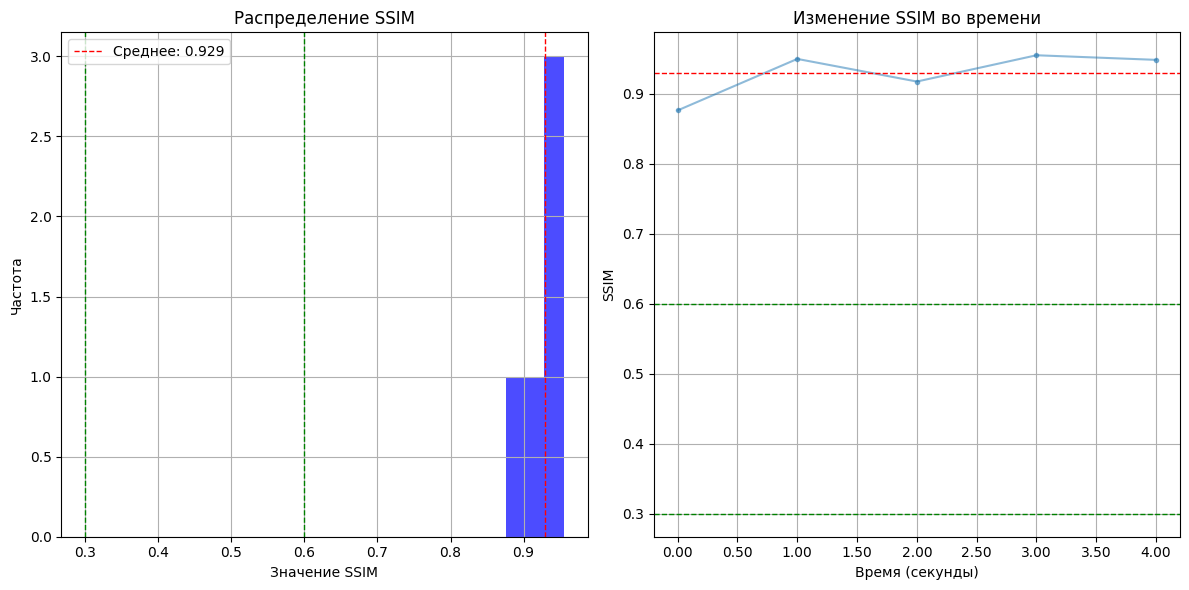

In [5]:
plot_ssim(video_path="./dataset/1.MOV", target_fps=1)


Результаты анализа SSIM:
Всего кадров: 12, Сравнений: 11
Средний SSIM: 0.941
Медиана SSIM: 0.957
Минимальный SSIM: 0.876
Максимальный SSIM: 0.974


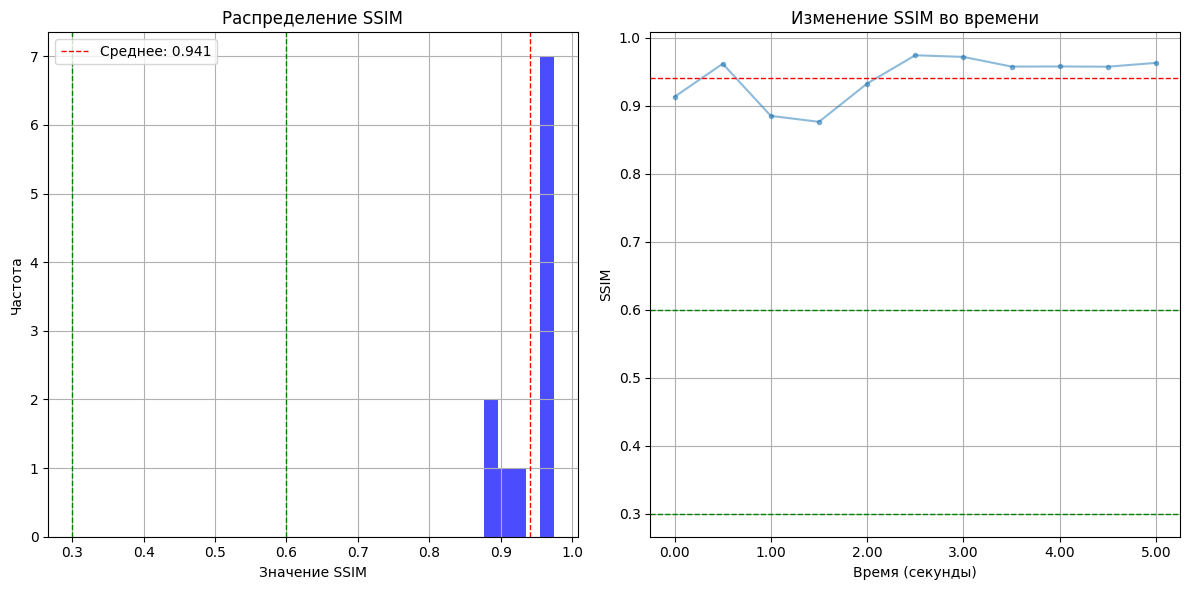

In [8]:
plot_ssim(video_path="./dataset/1.MOV", target_fps=2)


Результаты анализа SSIM:
Всего кадров: 30, Сравнений: 29
Средний SSIM: 0.957
Медиана SSIM: 0.970
Минимальный SSIM: 0.791
Максимальный SSIM: 0.980


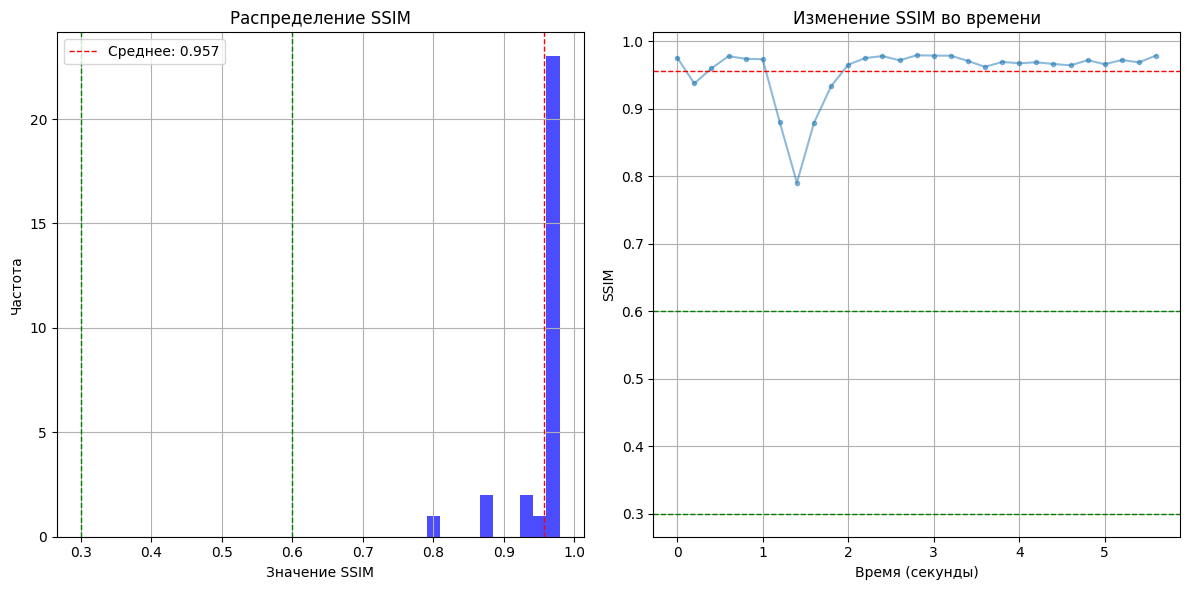

In [7]:
plot_ssim(video_path="./dataset/1.MOV", target_fps=5)


Результаты анализа SSIM:
Всего кадров: 60, Сравнений: 59
Средний SSIM: 0.973
Медиана SSIM: 0.978
Минимальный SSIM: 0.837
Максимальный SSIM: 0.988


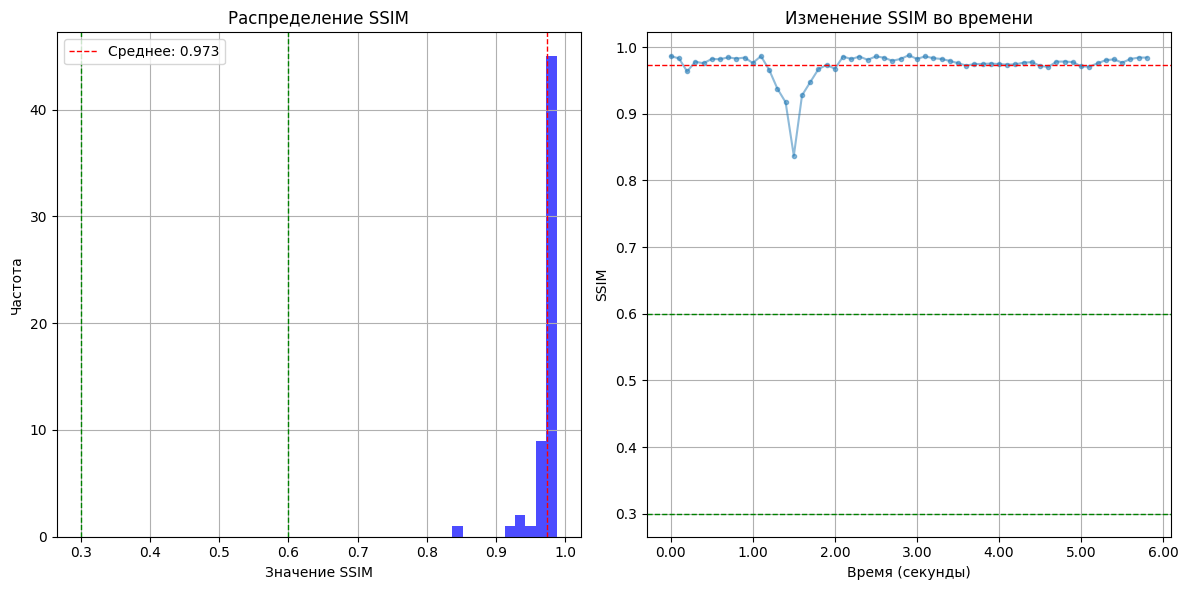

In [7]:
plot_ssim(video_path="./dataset/1.MOV", target_fps=10)

Как можно понять, сравнение по SSIM здесь не подходит ни при какой частоте кадров: большинство кадров почти полностью идентичны, 
падение мы видим только между первой и второй секундой, как раз на моменте, где камера затряслась, в то время как на моменте, где официантка принесла чайник, никакого значительноого изменения SSIM не происходит. Значит, избирать кадры на основе SSIM в данном случае - плохая идея. Вместо этого можно посмотреть результаты хрома-сегментации - в ней яркостная комнонента не будет учитываться, а будет учитываться только 


In [28]:
@dataclass
class VideoChromaDiffSchema:
    saved_count: int
    ratio_list: list[float]
    event_segments: list[tuple[int, int]]


def extract_motion_segments_by_chroma_diff(
    video_path: str,
    output_dir: str,
    chroma_thresh: float = 15.0,
    start_ratio: float = 0.005,
    end_ratio: float = 0.002,
    resize_factor: float = 0.5,
    intra_interval: float = 0
) -> VideoChromaDiffSchema:
    """
    Извлекает сегменты движения по цветовым сдвигам (Lab ab), игнорируя яркость.

    Args:
        video_path: путь к видео
        output_dir: директория для сохранения кадров
        chroma_thresh: порог цветового сдвига по ab-каналам
        start_ratio: доля пикселей для старта сегмента
        end_ratio: доля пикселей для завершения сегмента
        resize_factor: масштаб кадра для ускорения
        intra_interval: минимальный интервал (в секундах) между сохранениями внутри сегмента

    Returns:
        VideoChromaDiffSchema
    """
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Не удалось открыть видео: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    saved_count = 0
    event_active = False
    baseline_ab = None

    ratio_list: list[float] = []
    event_segments: list[tuple[int, int]] = []
    event_start_frame: int | None = None
    last_saved_time = -intra_interval

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        current_time = frame_idx / fps

        small = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
        lab = cv2.cvtColor(small, cv2.COLOR_BGR2Lab)
        ab = lab[..., 1:].astype(np.int16)

        if baseline_ab is None:
            baseline_ab = ab
            ratio_list.append(0.0)
            continue
        
        diff = np.abs(ab - baseline_ab)
        mask = np.any(diff > chroma_thresh, axis=2)
        ratio = mask.sum() / mask.size
        ratio_list.append(ratio)

        if not event_active and ratio >= start_ratio:
            event_active = True
            event_start_frame = frame_idx
            last_saved_time = current_time - intra_interval  # чтобы первый кадр сохранился сразу
            print(f"[Segment START] frame {frame_idx}: ratio={ratio:.4f}")

        if event_active:
            print(f"[Segment ongoing] frame {frame_idx}: ratio={ratio:.4f}")
            if current_time - last_saved_time >= intra_interval:
                path = os.path.join(output_dir, f"frame_{frame_idx:06d}.jpg")
                cv2.imwrite(path, frame)
                saved_count += 1
                last_saved_time = current_time

            if ratio < end_ratio:
                event_active = False
                if event_start_frame is not None:
                    event_segments.append((event_start_frame, frame_idx))
                baseline_ab = ab
                print(f"[Segment END] frame {frame_idx}: ratio={ratio:.4f}")
        
        # print(f"[Frame {frame_idx}] ratio={ratio:.4f} event_active={event_active}")
        
    cap.release()
    
    if event_active: # условие чисто для желтой отсечки на графике, иначе будет None и график не покажет границы сегмента
        event_segments.append((event_start_frame, frame_idx))
        print(f"[Segment END] frame {frame_idx}: (video end)")

    return VideoChromaDiffSchema(
        saved_count=saved_count,
        ratio_list=ratio_list,
        event_segments=event_segments
    )


In [5]:
def plot_chroma_diff_with_segments(
    ratio_values: list[float],
    fps: float,
    event_segments: list[tuple[int, int]],
    image_output_path: Optional[str] = None,
    grid_interval: Optional[float] = 0.2,
) -> None:
    if not ratio_values:
        print("Нет данных для отображения.")
        return

    avg_ratio = np.mean(ratio_values)
    median_ratio = np.median(ratio_values)

    plt.figure(figsize=(14, 6))

    times = np.arange(0, len(ratio_values)) * (1 / fps)

    # График линии ratio
    plt.plot(times, ratio_values, marker='o', markersize=3, linestyle='-', alpha=0.5, label='Ratio')
    plt.axhline(avg_ratio, color='r', linestyle='dashed', linewidth=1, label=f'Среднее: {avg_ratio:.4f}')

    # Вертикальные линии начала/конца сегментов
    for start_frame, end_frame in event_segments:
        start_time = start_frame / fps
        end_time = end_frame / fps
        plt.axvline(start_time, color='green', linestyle='dashed', linewidth=1)
        plt.axvline(end_time, color='orange', linestyle='dashed', linewidth=1)
        plt.fill_betweenx(
            [0, max(ratio_values) * 1.05],
            start_time,
            end_time,
            color='yellow',
            alpha=0.2
        )

    plt.xlabel('Время (секунды)')
    plt.ylabel('Доля изменившихся пикселей')
    plt.title('Изменение ratio по времени с разметкой сегментов')
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MultipleLocator(grid_interval))

    plt.tight_layout()

    if image_output_path:
        plt.savefig(image_output_path, dpi=300)
        print(f"Графики сохранены в {image_output_path}")

    plt.show()

In [20]:
first_video = extract_motion_segments_by_chroma_diff(
    './dataset/1.MOV',
    './keyframes/1_frames',
    chroma_thresh=15,
    start_ratio=0.01,
    end_ratio=0.005,
    resize_factor=0.5
)
print(f"Saved {first_video.saved_count} frames")

[Segment START] frame 126: ratio=0.0100
[Segment END] frame 152: ratio=0.0048
Saved 27 frames


Графики сохранены в ./keyframes/analytics/video1/var1.png


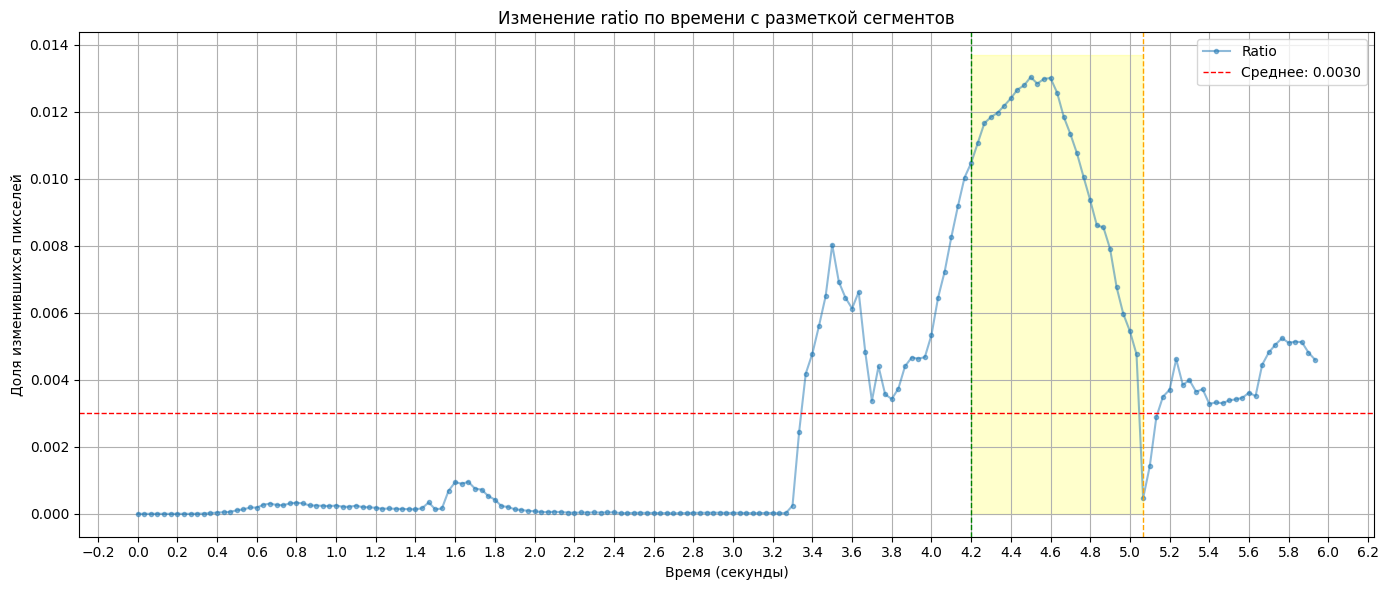

In [14]:
plot_chroma_diff_with_segments(
    ratio_values=first_video.ratio_list,
    fps=30,
    event_segments=first_video.event_segments,
    image_output_path="./keyframes/analytics/video1/var1.png"
)

Официантка приносит чайник как раз с четвертой секунды по пятую. Результат уже **гораздо** лучше, чем использование SSIM. Можно чуть уменьшить `intra_interval` потому что с начала детекции двжижения на первом видео мы сохранили избыточные 27 кадров. Так же можно уменьшить `start_ratio`, чтобы начала детекции началось раньше, видно, что у нас высоковат порог. `chroma_thresh` пока двигать не будем, чтобы не реагировать на шумы

In [19]:
first_video_var2 = extract_motion_segments_by_chroma_diff(
    './dataset/1.MOV',
    './keyframes/1_frames',
    chroma_thresh=15,
    start_ratio=0.005,
    end_ratio=0.005,
    resize_factor=0.5,
    intra_interval=0.15
)
print(f"Saved {first_video_var2.saved_count} frames")

[Segment START] frame 104: ratio=0.0056
[Segment END] frame 111: ratio=0.0048
[Segment START] frame 116: ratio=0.0051
[Segment END] frame 155: ratio=0.0049
Saved 10 frames


Уже достаточно хорошо. Аналогично будем разбивать остальные видео в датасете.<br> 
Далее без процесса размышлений, уже подобранные параматеры as fact.

In [52]:
%%capture
second_video = extract_motion_segments_by_chroma_diff(
    './dataset/2_1.MOV',
    './keyframes/2_1_frames',
    chroma_thresh=15,
    start_ratio=0.0106,
    end_ratio=0.010,
    resize_factor=0.5,
    intra_interval=0.35
)

In [54]:
print(f"Saved {second_video.saved_count} frames")

Saved 12 frames


Графики сохранены в ./keyframes/analytics/video2_1/var1.png


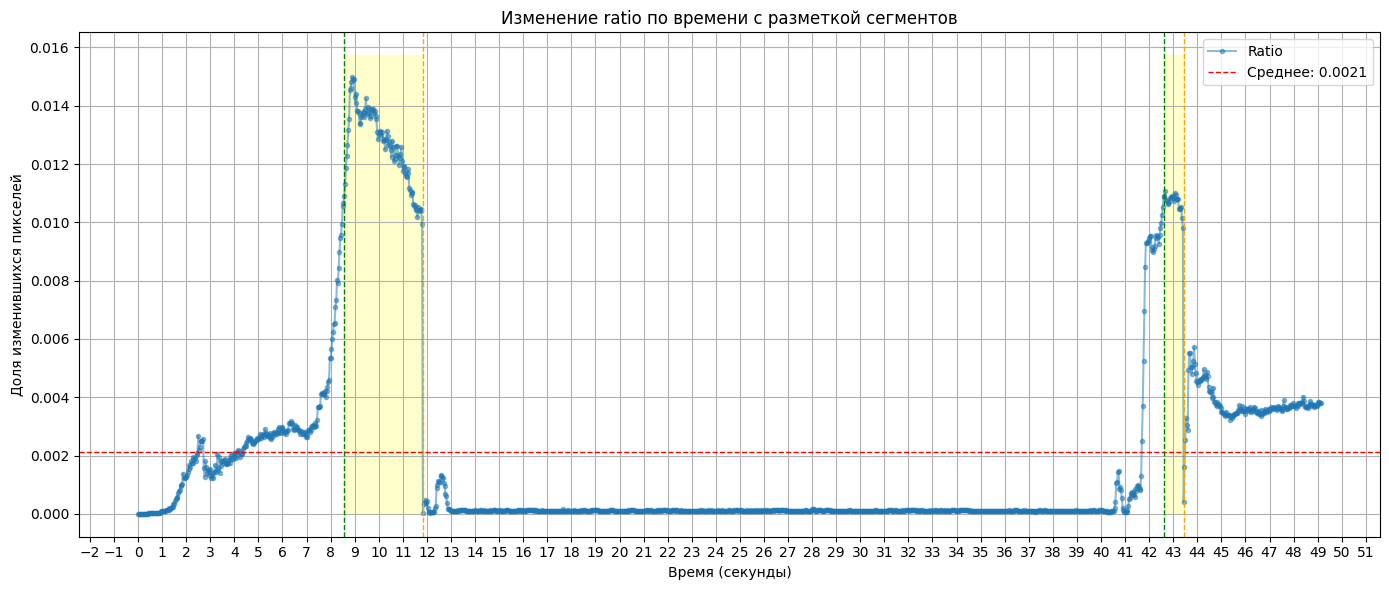

In [26]:
plot_chroma_diff_with_segments(
    ratio_values=second_video.ratio_list,
    fps=30,
    event_segments=second_video.event_segments,
    image_output_path="./keyframes/analytics/video2_1/var1.png",
    grid_interval=1
)

In [42]:
%%capture
third_video = extract_motion_segments_by_chroma_diff(
    './dataset/3_1.MOV',
    './keyframes/3_1_frames',
    chroma_thresh=15,
    start_ratio=0.0106,
    end_ratio=0.010,
    resize_factor=0.5,
    intra_interval=0.55
)

In [43]:
print(f"Saved {third_video.saved_count} frames")

Saved 171 frames


Графики сохранены в ./keyframes/analytics/video3_1/var1.png


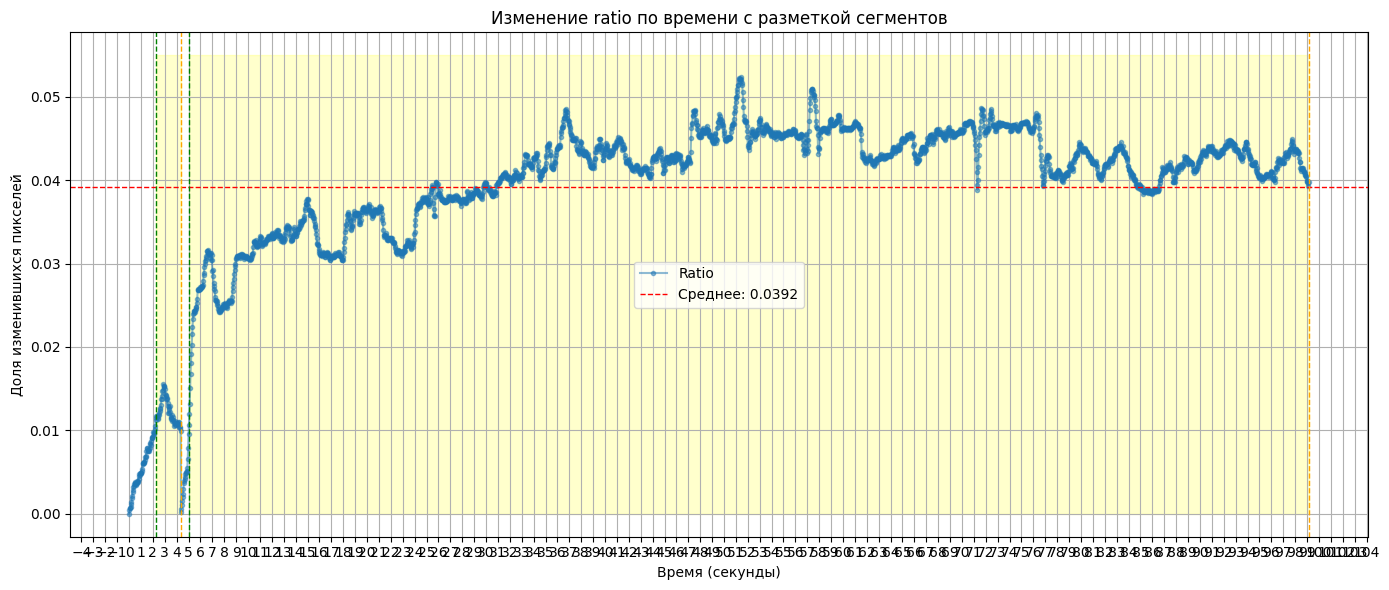

In [30]:
plot_chroma_diff_with_segments(
    ratio_values=third_video.ratio_list,
    fps=30,
    event_segments=third_video.event_segments,
    image_output_path="./keyframes/analytics/video3_1/var1.png",
    grid_interval=1
)

In [49]:
third_video2 = extract_motion_segments_by_chroma_diff(
    './dataset/3_2.MOV',
    './keyframes/3_2_frames',
    chroma_thresh=15,
    start_ratio=0.0106,
    end_ratio=0.010,
    resize_factor=0.5,
    intra_interval=0.35
)
print(f"Saved {third_video2.saved_count} frames")

[Segment START] frame 486: ratio=0.0108
[Segment ongoing] frame 486: ratio=0.0108
[Segment ongoing] frame 487: ratio=0.0110
[Segment ongoing] frame 488: ratio=0.0109
[Segment ongoing] frame 489: ratio=0.0111
[Segment ongoing] frame 490: ratio=0.0106
[Segment ongoing] frame 491: ratio=0.0106
[Segment ongoing] frame 492: ratio=0.0104
[Segment ongoing] frame 493: ratio=0.0101
[Segment ongoing] frame 494: ratio=0.0098
[Segment END] frame 494: ratio=0.0098
[Segment START] frame 1098: ratio=0.0110
[Segment ongoing] frame 1098: ratio=0.0110
[Segment ongoing] frame 1099: ratio=0.0101
[Segment ongoing] frame 1100: ratio=0.0096
[Segment END] frame 1100: ratio=0.0096
[Segment START] frame 1194: ratio=0.0107
[Segment ongoing] frame 1194: ratio=0.0107
[Segment ongoing] frame 1195: ratio=0.0107
[Segment ongoing] frame 1196: ratio=0.0108
[Segment ongoing] frame 1197: ratio=0.0108
[Segment ongoing] frame 1198: ratio=0.0101
[Segment ongoing] frame 1199: ratio=0.0086
[Segment END] frame 1199: ratio=0.00

Графики сохранены в ./keyframes/analytics/video3_2/var1.png


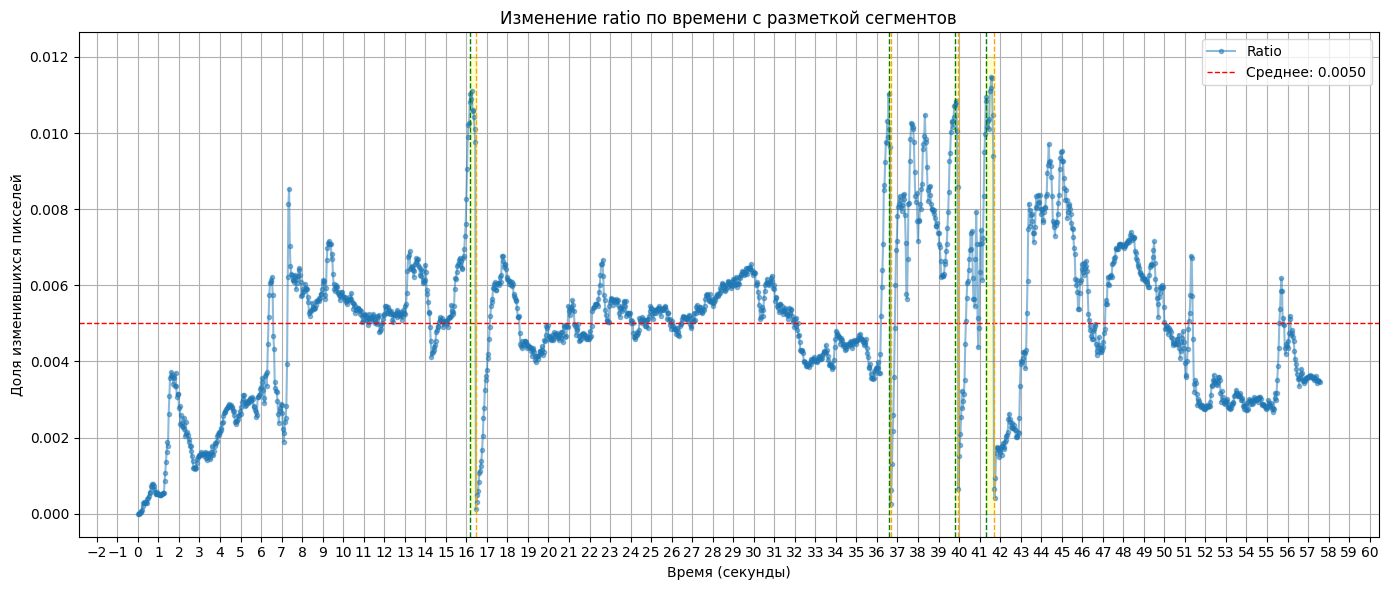

In [34]:
plot_chroma_diff_with_segments(
    ratio_values=third_video2.ratio_list,
    fps=30,
    event_segments=third_video2.event_segments,
    image_output_path="./keyframes/analytics/video3_2/var1.png",
    grid_interval=1
)

In [48]:
%%capture
fourth_video = extract_motion_segments_by_chroma_diff(
    './dataset/4.MOV',
    './keyframes/4_1_frames',
    chroma_thresh=15,
    start_ratio=0.04,
    end_ratio=0.038,
    resize_factor=0.5,
    intra_interval=0.5
)
print(f"Saved {fourth_video.saved_count} frames")

Графики сохранены в ./keyframes/analytics/video4/var1.png


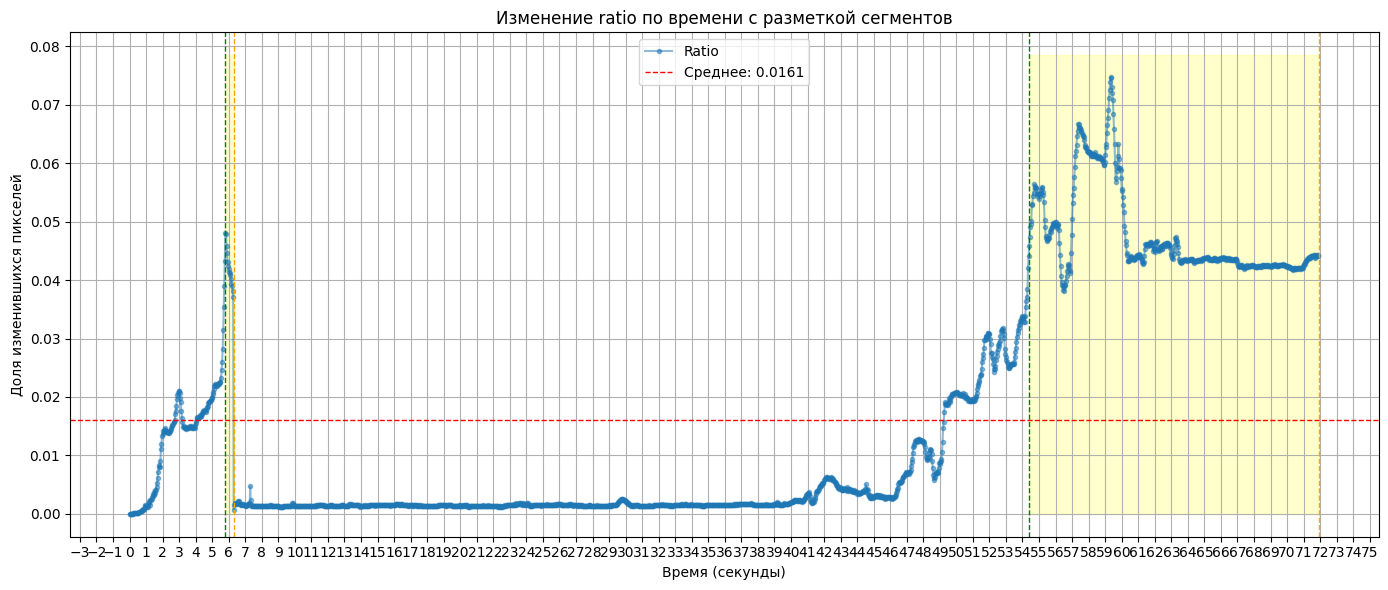

In [41]:
plot_chroma_diff_with_segments(
    ratio_values=fourth_video.ratio_list,
    fps=30,
    event_segments=fourth_video.event_segments,
    image_output_path="./keyframes/analytics/video4/var1.png",
    grid_interval=1
)

In [44]:
%%capture
fourth_video1 = extract_motion_segments_by_chroma_diff(
    './dataset/4_1.MOV',
    './keyframes/4_frames',
    chroma_thresh=15,
    start_ratio=0.04,
    end_ratio=0.038,
    resize_factor=0.5,
    intra_interval=0.55
)

In [45]:
print(f"Saved {fourth_video1.saved_count} frames")

Saved 10 frames


Графики сохранены в ./keyframes/analytics/video4_1/var1.png


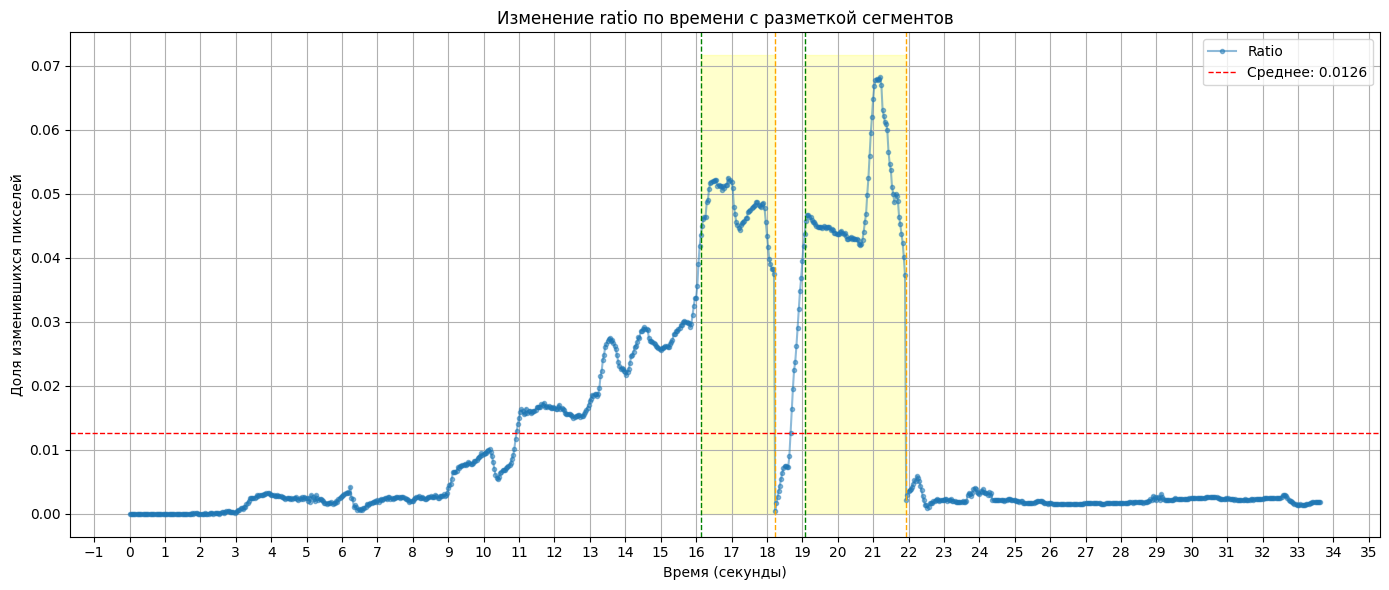

In [47]:
plot_chroma_diff_with_segments(
    ratio_values=fourth_video1.ratio_list,
    fps=30,
    event_segments=fourth_video1.event_segments,
    image_output_path="./keyframes/analytics/video4_1/var1.png",
    grid_interval=1
)

## Аннотация

В рамках данной задачи была использована Bounding Box разметка для разных классов блюд (DISH1, DISH2, DISH3 и т. д.), polygon или instance mask был бы избыточен, нам достаточно просто локализации объекта без распознавания его точных контуров.

## Аугментация и разбивка тестовых данных

Для данной задачи был смысл использовать все стандартные геометрические трансформации (повороты, случайное масштабирование, случайное отражение по горизонтали), фотометрические изменения (изменение яркости, контрастности, гаммы, сдвиг оттенков), а также шум и размытие для повышения устойчивости модели к разным условиям съёмки.

Такие трансформации, как случайная перестановка сетки (`RandomGridShuffle`) и сильное искажение перспективы, использованы не были, потому что они существенно изменяют пространственное расположение объектов и могут привести к несоответствию между исходным изображением и метками ограничивающих рамок. В задаче детекции блюд важно, чтобы геометрическая структура сцены сохранялась, и объекты оставались узнаваемыми по форме.


In [110]:
import cv2
import albumentations as A
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
import shutil

In [111]:
transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        A.RandomResizedCrop(
            size=(640, 640),
            scale=(0.8, 1.0),
            ratio=(0.75, 1.333),
            p=0.3
        ),
        A.MotionBlur(blur_limit=5, p=0.3),
        A.ISONoise(color_shift=(0.01, 0.05), p=0.3),
    ], p=1.0),

    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.7),
    ], p=0.8),

    A.OneOf([
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.RandomGridShuffle(grid=(3, 3), p=0.3),
    ], p=0.5),
],
bbox_params=A.BboxParams(
    format='yolo',
    min_area=100,
    min_visibility=0.3,
    label_fields=['class_labels']
))

Не отходя далеко от кассы, сразу разобьем на train/val/test

In [113]:
FRAMES_DIR     = Path("./keyframes")
ANNOT_DIR      = Path("./annotations")
OUT_ROOT       = Path("augmented_dataset")
VIDEO_GROUPS   = ["1", "2_1", "3_1", "3_2", "4", "4_1"]
NUM_AUG_PER_IMG = 2
TEST_SIZE      = 0.15
VAL_SIZE       = 0.15
SEED           = 42

def read_labels(p: Path):
    b, c = [], []
    for L in p.read_text().splitlines():
        cid, x, y, w, h = map(float, L.split())
        b.append([x,y,w,h]); c.append(int(cid))
    return b, c

def save_labels(bboxes: list[list[float]], classes: list[int], p: Path):
    p.parent.mkdir(exist_ok=True, parents=True)
    with open(p, 'w') as f:
        for cid, (x,y,w,h) in zip(classes, bboxes):
            f.write(f"{cid} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def augment_and_copy(img_p: Path, lbl_p: Path, out_img_p: Path, out_lbl_p: Path):
    out_img_p.parent.mkdir(exist_ok=True, parents=True)
    shutil.copy(img_p, out_img_p)
    save_labels(*read_labels(lbl_p), out_lbl_p)
    bboxes, classes = read_labels(lbl_p)
    img = cv2.imread(str(img_p))[:,:,::-1]
    for i in range(NUM_AUG_PER_IMG):
        aug = transform(image=img, bboxes=bboxes, class_labels=classes)
        aug_img = aug['image'][:,:,::-1]
        aug_b, aug_c = aug['bboxes'], aug['class_labels']
        ai = out_img_p.with_name(out_img_p.stem + f"_aug{i}" + out_img_p.suffix)
        al = out_lbl_p.with_name(out_lbl_p.stem + f"_aug{i}.txt")
        cv2.imwrite(str(ai), aug_img)
        save_labels(aug_b, aug_c, al)

items, groups = [], []
for grp in VIDEO_GROUPS:
    frame_dir = FRAMES_DIR / f"{grp}_frames"
    ann_dir   = ANNOT_DIR / grp / "obj_train_data"
    for img in frame_dir.glob("*.jpg"):
        lbl = ann_dir / f"{img.stem}.txt"
        if lbl.exists():
            items.append((img, lbl))
            groups.append(grp)

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
train_val_idx, test_idx = next(gss.split(items, groups=groups))
gss2 = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=SEED)
train_idx, val_idx = next(gss2.split([items[i] for i in train_val_idx], 
                                      groups=[groups[i] for i in train_val_idx]))

def process_split(idxs, name):
    for idx in idxs:
        img, lbl = items[idx]
        out_img = OUT_ROOT / name / "images" / f"{img.parent.stem}_{img.name}"
        out_lbl = OUT_ROOT / name / "labels" / f"{img.parent.stem}_{lbl.name}"
        augment_and_copy(img, lbl, out_img, out_lbl)
    print(f"{name}: {len(idxs)} файлов обработано")

for s in ["train","val","test"]:
    (OUT_ROOT/s/"images").mkdir(parents=True, exist_ok=True)
    (OUT_ROOT/s/"labels").mkdir(parents=True, exist_ok=True)

process_split(train_idx, "train")
process_split(val_idx,   "val")
process_split(test_idx,  "test")

train: 40 файлов обработано
val: 171 файлов обработано
test: 10 файлов обработано


## Тестирование гиперпараметров

## Гиперпараметры

В обучении использовалось несколько гипотез с разными конфигурациями параметров, чтобы проверить влияние скорости обучения, регуляризации и фотометрических искажений на итоговые метрики.

### Гипотеза 1: Умеренное обучение и усиленная цветовая аугментация

- **Learning rate (`lr0=0.005`)**
  Небольшое значение, чтобы избежать перескоков через минимумы на относительно небольшом датасете. Подбиралось эмпирически, начиная с `0.01` и снижая шаг при колебаниях потерь.

- **Momentum (`0.937`)**
  Взято из рекомендаций YOLOv5/YOLOv8 (диапазон 0.9–0.95). Чуть ниже 0.95, чтобы быстрее реагировать на изменение направления градиента и ускорять сходимость.

- **Weight decay (`0.0005`)**
  Минимальное значение для слабой регуляризации, не будет резко запоминает шум

- **HSV-растяжение (`hsv_h=0.015`, `hsv_s=0.7`, `hsv_v=0.4`)**
  Сильные сдвиги насыщенности и яркости имитируют реальное разнообразие освещения ресторанов и съёмку разными устройствами.
  При этом `hsv_h` ограничен, так как сильный сдвиг оттенка меняет визуальное восприятие блюда (например, мясо может казаться зелёным).

- **Batch size (`16`)**
  Выбран с учётом доступной памяти GPU, чтобы сохранить разумную статистику градиентов при одном проходе

- **Patience (`20`)**
  Позволяет не останавливать обучение слишком рано при временной плато метрик

---

### Гипотеза 2: Более высокий learning rate и сильнее weight decay

- **Learning rate (`lr0=0.01`)**
  Увеличение шага обучения для проверки, ускорится ли сходимость и удастся ли быстрее выйти на плато.

- **Weight decay (`0.005`)**
  Сильнее регуляризация, чтобы снизить переобучение в условиях аугментированного датасета.

- **Momentum (`0.937`)**
  Оставлен без изменений для чистоты эксперимента.

Ожидание: модель быстрее сойдётся, но может сильнее скакать метрика качества

---

### Гипотеза 3: Минимальное влияние цветовой аугментации

- **HSV-растяжение (`hsv_h=0.0`, `hsv_s=0.2`, `hsv_v=0.2`)**
  Почти отключённое изменение цвета, чтобы оценить, насколько модель действительно использует цвет при распознавании.

Ожидание: модель может показывать чуть лучшие результаты на чистых валидационных данных, но хуже справляться с фото при других условиях освещения

---

## Результаты

Лучшей оказалась гипотеза `low_color_aug`, потому что она показала:

- наивысшее значение `mAP@0.5 = 0.992`, почти безошибочная локализация объектов,
- максимальное значение `mAP@0.5:0.95 = 0.934`, высокая точность при разных IoU-порогах,
- стабильную сходимость без переобучения.

Такой результат объясняется тем, что умеренные фотометрические аугментации делают модель более устойчивой к разным условиям освещения, при этом не нарушая цветовую информативность блюд. Слишком сильные цветовые искажения или чрезмерное регуляризующее воздействие weight decay не дали улучшения качества.


# Отчёт о результатах обучения модели YOLO

## Общий прогресс обучения

### Результаты обучения по эпохам
![results](./runs_zebra_dishes/low_color_aug/results.png)

> Сводный график изменения потерь (loss), точности (precision), полноты (recall) и mAP по эпохам.
> Видно, что модель быстро выходит на плато и не переобучается — метрики стабилизируются без резкого роста потерь на валидации.

---

## Оценка качества модели

### Precision-Recall кривая
![PR Curve](./runs_zebra_dishes/low_color_aug/PR_curve.png)

> Кривая зависимости полноты от точности при разных confidence-порогах.
> Площадь под кривой близка к 1.0, что подтверждает хорошее общее качество классификации и локализации.

---

### F1-score по порогам confidence
![F1 Curve](./runs_zebra_dishes/low_color_aug/F1_curve.png)

> График максимального F1-значения при различных confidence-порогах.
> Оптимальный баланс точности и полноты достигается при confidence ≈ 0.3–0.4.

---

### Точность (Precision) по confidence
![P Curve](./runs_zebra_dishes/low_color_aug/P_curve.png)

> Точность модели высока (около 1.0) даже при низком confidence.
> Это означает, что ложных положительных срабатываний почти нет.

---

### Полнота (Recall) по confidence
![R Curve](./runs_zebra_dishes/low_color_aug/R_curve.png)

> Полнота остаётся высокой при умеренных confidence-порогах, но падает при слишком высоких, как ожидается.
> Модель надёжно находит большинство объектов при confidence ≥ 0.3.

---

## Ошибки классификации и структура данных

### Матрица ошибок
![Confusion Matrix](./runs_zebra_dishes/low_color_aug/confusion_matrix.png)

![Confusion Matrix Normalized](./runs_zebra_dishes/low_color_aug/confusion_matrix_normalized.png)

> Матрица ошибок по классам.
> Диагональное преобладание и отсутствие сильных перекрёстных классов говорят о хорошей различимости между блюдами.

---

### Распределение классов и размеров объектов
![Labels](./runs_zebra_dishes/low_color_aug/labels.jpg)

![Labels Correlogram](./runs_zebra_dishes/low_color_aug/labels_correlogram.jpg)

> Распределение размеров и количества объектов по кадрам и классам.
> Видно, что большинство объектов компактны по размеру и сбалансированы по классам, переобучения на один класс не наблюдается.

## Выводы

- Модель продемонстрировала высокую точность и полноту по большинству метрик.
- Показатели mAP50 и mAP50-95 стабильно высоки.
- Ошибок классификации практически нет.
- Модель устойчива к различным условиям аугментации и съёмки.